# 异源图像变化检测

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import imageio

import os
import cv2

import torch
import torch.nn as nn

## 同源数据集（未校正）

`SZTAKI`数据集一共有 `13` 幅图片, 图片为 952x640x3 (W,H,C). 

    - `Tiszadob` : `5` 幅图片
    
    - `Szada` : `7` 幅图片
    
    - `Archieve` : `1` 幅图片
    

包含有5种变化：  

    - new built-up regions   
    
    - building operations   
    
    - planting of large group of trees   
    
    - fresh plough-land   
    
    - groundwork before building over  



### 所有图片展示

In [2]:
im1s = []
im2s = []
gts = []

for root,folder,files in os.walk('datasets/source/SZTAKI_AirChange_Benchmark/'):
    for file in files:
        if file[:3]=='im1':
            im1s.append(root+'/'+file)
        elif file[:3]=='im2':
            im2s.append(root+'/'+file)
        else:
            gts.append(root+'/'+file)
print('\n'.join(im1s))

datasets/source/SZTAKI_AirChange_Benchmark/Archieve/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\1/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\2/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\3/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\4/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\5/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\6/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Szada\7/im1.BMP
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\1/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\2/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\3/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\4/im1.bmp
datasets/source/SZTAKI_AirChange_Benchmark/Tiszadob\5/im1.bmp


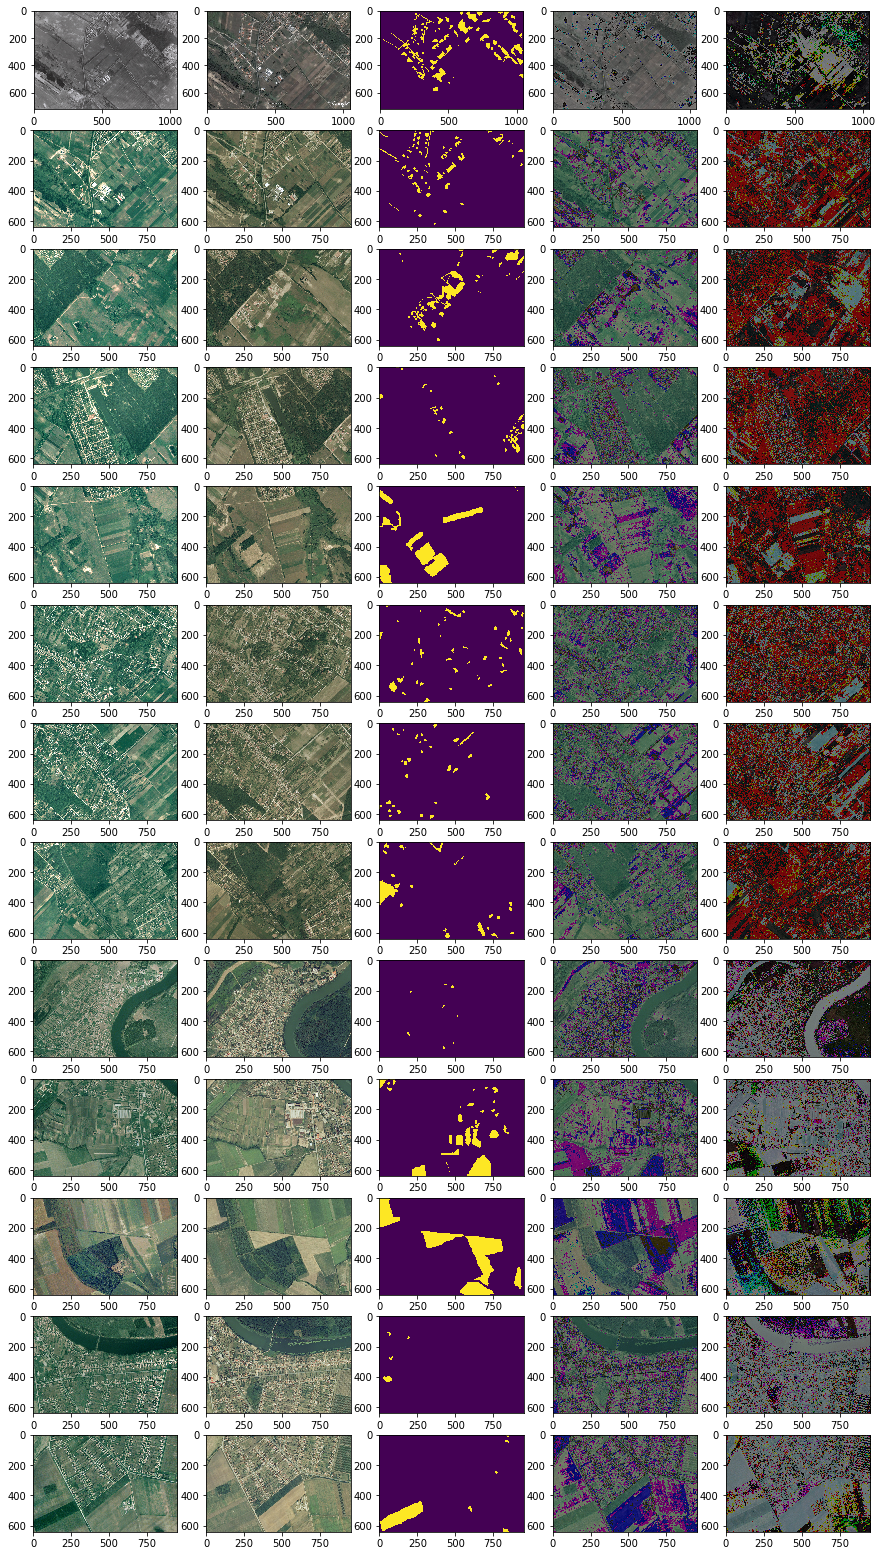

In [3]:
plt.figure(1,figsize=(15,28))
for i in range(13):
    im1 = mpimg.imread(im1s[i])
    im2 = mpimg.imread(im2s[i])
    gt = mpimg.imread(gts[i])
    plt.subplot(13,5,i*5+1)
    plt.imshow(im1)
    plt.subplot(13,5,i*5+2)
    plt.imshow(im2)
    plt.subplot(13,5,i*5+3)
    plt.imshow(gt)
    plt.subplot(13,5,i*5+4)
    plt.imshow((im1+im2)//2)
    plt.subplot(13,5,i*5+5)
    plt.imshow((im1-im2)//2)
plt.show()

## 异源数据集

包含四对（1/10/82/3879）光学图像和SAR图像

三个通道，且每个通道完全相同

需要注意的是，原数据集中，有的im1和im2大小不一样并且有的是三个通道，有的是四个通道

In [4]:
im1s = []
im2s = []
gts = []

for root,folder,files in os.walk('datasets/Heterogeneous/source'):
    for file in files:
        if 'opt.png' in file:
            im1s.append(root+'/'+file)
        elif 'sar.png' in file:
            im2s.append(root+'/'+file)
        elif 'gt' in file and '_' not in file:
            gts.append(root+'/'+file)
print('\n'.join(im1s+im2s+gts))

datasets/Heterogeneous/source/10opt.png
datasets/Heterogeneous/source/1opt.png
datasets/Heterogeneous/source/3879opt.png
datasets/Heterogeneous/source/82opt.png
datasets/Heterogeneous/source/10sar.png
datasets/Heterogeneous/source/1sar.png
datasets/Heterogeneous/source/3879sar.png
datasets/Heterogeneous/source/82sar.png
datasets/Heterogeneous/source/10gt.png
datasets/Heterogeneous/source/1gt.png
datasets/Heterogeneous/source/3879gt.png
datasets/Heterogeneous/source/82gt.png


(1096, 1439, 3) (1096, 1439, 3) (1096, 1438, 3)
(815, 800, 3) (815, 800, 3) (814, 800, 3)
(866, 1250, 3) (866, 1250, 3) (866, 1250, 4)
(1271, 1200, 3) (1271, 1200, 3) (1270, 1200, 3)


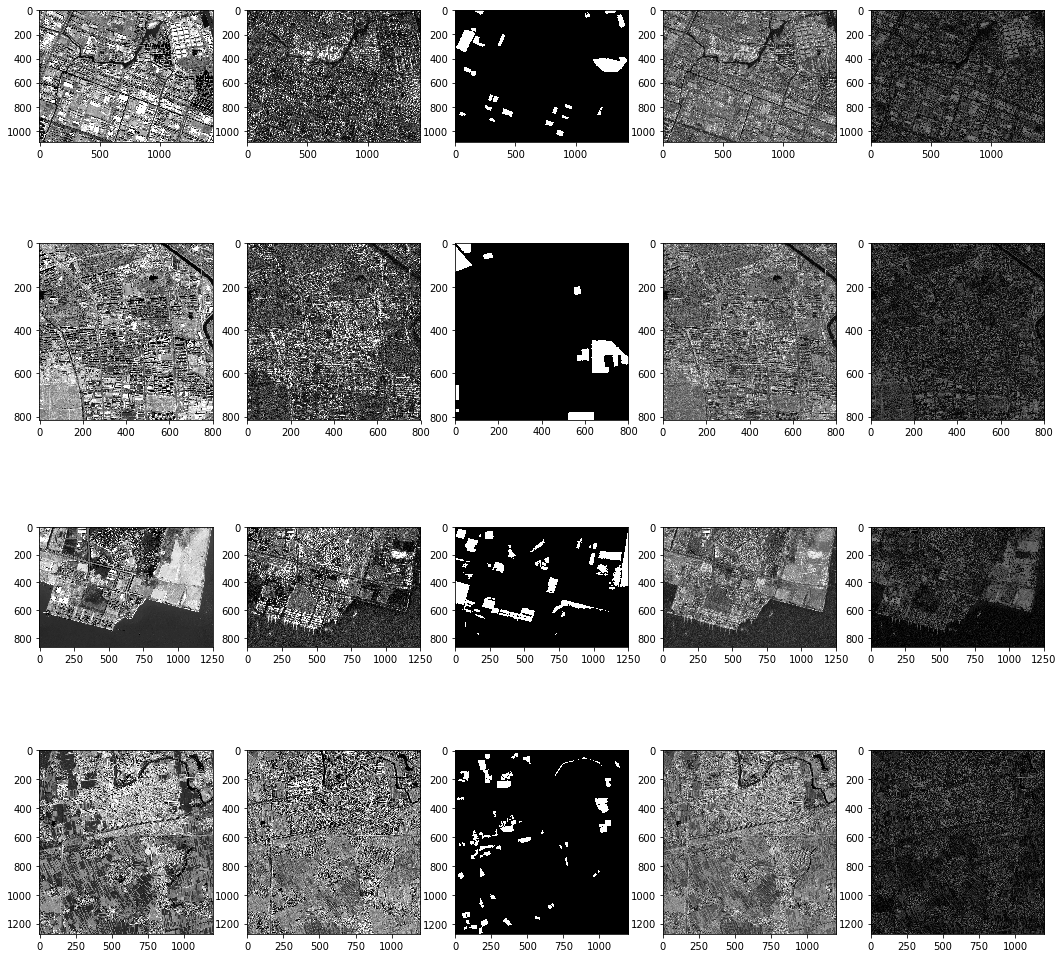

In [31]:
n_pair = len(im1s)

plt.figure(1,figsize=(18,18))
for i in range(n_pair):
    im1 = mpimg.imread(im1s[i])
    im2 = mpimg.imread(im2s[i])
    gt = mpimg.imread(gts[i])
    print(im1.shape,im2.shape,gt.shape)
    plt.subplot(n_pair,5,i*5+1)
    plt.imshow(im1,cmap='gray')
    plt.subplot(n_pair,5,i*5+2)
    plt.imshow(im2,cmap='gray')
    plt.subplot(n_pair,5,i*5+3)
    plt.imshow(gt,cmap='gray')
    plt.subplot(n_pair,5,i*5+4)
    plt.imshow((im1+im2)/2)
    plt.subplot(n_pair,5,i*5+5)
    plt.imshow(abs(im1-im2)/2)
plt.show()

### 异源数据分析

In [7]:
for im1,im2,gt in zip(im1s,im2s,gts):
# #     print('unprocessed:',im1,im2,gt,sep='\t\t\t')
    t1 = cv2.imread(im1)
    t2 = cv2.imread(im2)
    tg = cv2.imread(gt)
    print(t1.shape,t2.shape,tg.shape)
# # #     print((im1[:,:,1]-im1[:,:,0]).any(),(im1[:,:,2]-im1[:,:,0]).any(),\
# # #          (im2[:,:,1]-im2[:,:,0]).any(),(im2[:,:,2]-im2[:,:,0]).any(),\
# # #          (gt[:,:,1]-gt[:,:,0]).any(),(gt[:,:,2]-gt[:,:,0]).any())
# #     H,W,C = tg.shape
    
#     im1.replace('source/','')
#     im2.replace('source/','')
#     gt.replace('source/','')
    
# #     mpimg.imsave(im1,t1[:H,:W,:C])
# #     mpimg.imsave(im2,t2[:H,:W,:C])
# #     mpimg.imsave(gt,tg[:H,:W,:C])

#     cv2.imwrite(im1,t1[:H,:W,:3])
#     cv2.imwrite(im2,t2[:H,:W,:3])
#     cv2.imwrite(gt,tg[:H,:W,:3])



(1096, 1200, 3) (1096, 1200, 3) (1096, 1200, 3)
(814, 800, 3) (814, 800, 3) (814, 800, 3)
(866, 1200, 3) (866, 1200, 3) (866, 1200, 3)
(1270, 1200, 3) (1270, 1200, 3) (1270, 1200, 3)


In [21]:
tg = mpimg.imread(gt)[:,:,0:1]
print(tg.shape)
mask = np.concatenate((tg,1-tg),axis=2)
print(mask.shape,gt.replace('gt.png','mask.png').replace('source/',''))
imageio.imwrite(gt.replace('gt.png','mask.png'),mask[:,:,:1])


(1270, 1200, 1)
(1270, 1200, 2) datasets/Heterogeneous/82mask.png


In [33]:
x1 = torch.autograd.Variable(torch.rand(4,2,112,112))
x2 = torch.autograd.Variable(torch.rand(4,2,112,112))

In [49]:
x = nn.Softmax(dim=1)((x1))
x.shape

torch.Size([4, 2, 112, 112])

In [50]:
x[1,:,1,1]

tensor([0.5779, 0.4221])

In [55]:
y = torch.argmax(x,dim=1,keepdim=True)
print(y.shape,y)

torch.Size([4, 1, 112, 112]) tensor([[[[1, 0, 0,  ..., 0, 1, 1],
          [0, 1, 0,  ..., 0, 1, 1],
          [0, 0, 0,  ..., 0, 1, 0],
          ...,
          [0, 1, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 1, 1],
          [0, 0, 0,  ..., 0, 0, 1]]],


        [[[1, 1, 1,  ..., 0, 1, 1],
          [1, 0, 1,  ..., 1, 0, 1],
          [0, 0, 0,  ..., 0, 1, 1],
          ...,
          [1, 1, 0,  ..., 0, 1, 1],
          [1, 1, 1,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 1, 1]]],


        [[[0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 1, 0],
          [1, 1, 0,  ..., 0, 1, 1],
          ...,
          [1, 0, 0,  ..., 1, 1, 1],
          [0, 0, 1,  ..., 0, 1, 1],
          [1, 0, 0,  ..., 1, 1, 1]]],


        [[[0, 0, 1,  ..., 1, 0, 0],
          [0, 1, 0,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 1, 0, 1],
          ...,
          [0, 1, 0,  ..., 0, 0, 1],
          [0, 1, 1,  ..., 1, 1, 1],
          [0, 1, 0,  ..., 1, 1, 1]]]])


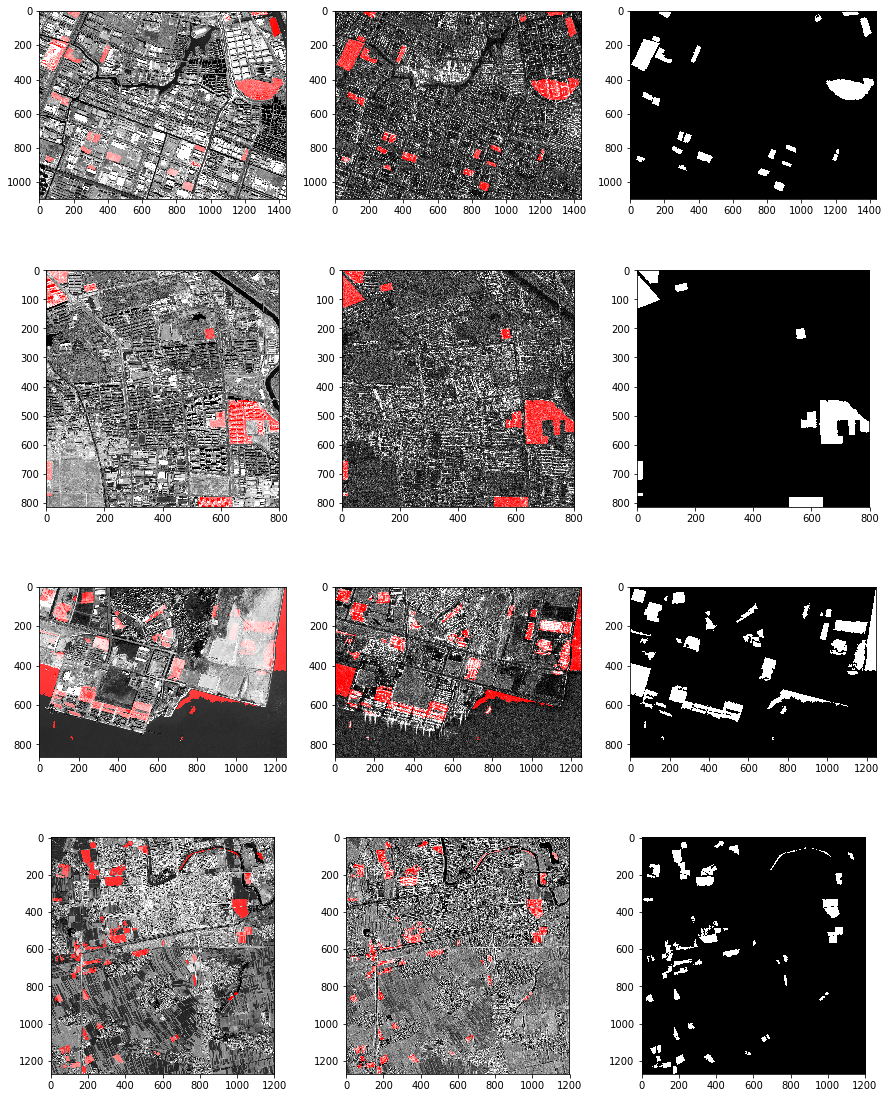

In [35]:
# t1 = im1.copy() # temp im1
# t2 = im2.copy()
# tg = gt.copy()

N = len(im1s) # number of pairs
bins = 200

# plt.figure(figsize=(10,20),num=1)
# plt.suptitle('Histograms of pairs')
# for i in range(N):
#     im1 = mpimg.imread(im1s[i])[:,:,1]
#     im2 = mpimg.imread(im2s[i])[:,:,1]
#     gt = mpimg.imread(gts[i])[:,:,1]
#     plt.subplot(N,2,i*2+1)
#     plt.hist(im1.reshape((-1,1)),bins=bins)
#     plt.subplot(N,2,i*2+2)
#     plt.hist(im2.reshape((-1,1)),bins=bins)
# plt.show()

plt.figure(num=2,figsize=(15,20))
for i in range(N):
    im1 = mpimg.imread(im1s[i])[:,:,:3]
    t1 = im1.copy()
    im2 = mpimg.imread(im2s[i])[:,:,:3]
    t2 = im2.copy()
    gt = mpimg.imread(gts[i])[:,:,:3]
    tg = gt.copy()
    
    if t1.shape != tg.shape:
        H,W,C = tg.shape
        t1 = t1[:H,:W,:C]
        t2 = t2[:H,:W,:C]
        
#     print(t1.shape,gt.shape)

    t1[:,:,0][tg[:,:,0]==1.0] = 1.0
    t2[:,:,0][tg[:,:,0]==1.0] = 1.0
    
#     print(t1.shape,t2.shape,tg.shape)
    
    plt.subplot(N,3,i*3+1)
    plt.imshow(t1)
    plt.subplot(N,3,i*3+2)
    plt.imshow(t2)
    plt.subplot(N,3,i*3+3)
    plt.imshow(tg)
    
#     mpimg.imsave(im1s[i].replace('opt','opt_gt'),t1)
#     mpimg.imsave(im2s[i].replace('sar','sar_gt'),t2)
    
plt.show()
    
    
    



## 网络搭建

In [96]:
# %load models.py
# 用来存放模型的脚本
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


class loss(nn.Module):
    def __init__(self):
        super(loss, self).__init__()
        self.m = 5e-4
        
    def forward(self, D, Y):
        loss = 0.0
        m = self.m  # 可能设置为一个可以学习的参数
        D = D.cpu().detach().numpy()
        Y = Y.cpu().detach().numpy()
        w_u = 0.7
        w_c = 0.3
        loss = np.sum(Y*pow(np.maximum(0, m-D), 2)*w_c + (1-Y)*pow(D, 2)*w_u) / 2

        return torch.tensor(loss, requires_grad=True)


class SiameseNet(nn.Module):
    # 卷积过程中feature map大小不变的卷积网络
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.featureExtract = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 64, 5, padding=2),
            nn.Conv2d(64, 32, 5, padding=2),
            nn.Conv2d(32, 16, 1, padding=0),
        )
        self.distance = nn.PairwiseDistance(p=2)

    def forward(self, x1, x2):
        x1 = self.featureExtract(x1)
        x2 = self.featureExtract(x2)
        x = self.distance(x1, x2)

        return x

class Siamese_diff_add(nn.Module):
    # 双通道，一个用来学习相同特征，一个用来学习不同特征
    def __init__(self):
        super(Siamese_diff_add, self).__init__()
        self.add_stage = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
        )
        
        self.diff_stage = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm1d(64),
#             nn.MaxPool2d(3,stride=2),
            nn.ReLU() # inplace=True
            
        )

    def forward(self,im1,im2):
        im_add = (im1 + im2) / 2
        im_diff = (im1 - im2) / 2
        
        x_add = self.add_stage(im_add)
        x_diff = self.diff_stage(im_diff)
        
        
        
        return

        


if __name__ == "__main__":
    net = SiameseNet()
    print(net)
    # print(list(net.parameters()))


SiameseNet(
  (featureExtract): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (distance): PairwiseDistance()
)


Object `nn.ReLU` not found.
